<a href="https://colab.research.google.com/github/CIA-Oceanix/DLCourse_MOi_2022/blob/main/notebooks/notebook_MNIST_classification_MLP_with_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep classification on Fashion-MNIST using pytorch


---



## 1- Data management <a class="anchor" id="section_1"></a>

Start with these lines of code to automatically download the Fashion-MNIST dataset.

In [1]:
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor()

#train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = transform)
#test_data = datasets.FashionMNIST(root = 'data', train = False, download = True, transform = transform)

train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



#### **Size and structure of MNIST Datasets** - MNIST (Fashion-MNIST) is a dataset consisting of a training set of A examples and a test set of B examples. Each example is a CxC grayscale image, associated with a label from D classes. What are the values for A, B, C and D? <a class="anchor" id="question_1_1"></a>

In [2]:
num_train, num_test = len(train_data), len(test_data) # TO DO
print('A =', num_train) # TO DO
print('B =', num_test) # TO DO
print('C =', train_data.data.shape[1]) # TO DO
print('D =', len(train_data.classes)) # TO DO

A = 60000
B = 10000
C = 28
D = 10


#### **Recover the labels of the classes** of MNIST dataset

In [3]:
class_names = train_data.classes
print(class_names)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


#### **Dataloader creation** - Check data loader documentation ([documentation](https://pytorch.org/docs/stable/data.html)) for training, validation and test sets. <a class="anchor" id="question_1_2"></a>

In [60]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

batch_size = 20
valid_size = 0.2

train_size = 0.2
indices = np.random.permutation(len(train_data))[:int(train_size*len(train_data))]
train_data = torch.utils.data.Subset(train_data,indices )

def create_data_loaders(batch_size, valid_size, train_data, test_data): # FUNCTION TO BE COMPLETED

  total_train = len(train_data)
  num_val = int(total_train * valid_size)
  num_train = total_train - num_val

  tr_data, val_data = torch.utils.data.random_split(train_data, [num_train, num_val])
  train_loader = torch.utils.data.DataLoader(tr_data, batch_size = batch_size)
  valid_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

  return train_loader, valid_loader, test_loader

In [61]:
train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data) # TO DO

#### **MNIST samples** - Visualize some images from the training set with corresponding ground truth labels. <a class="anchor" id="question_1_3"></a>

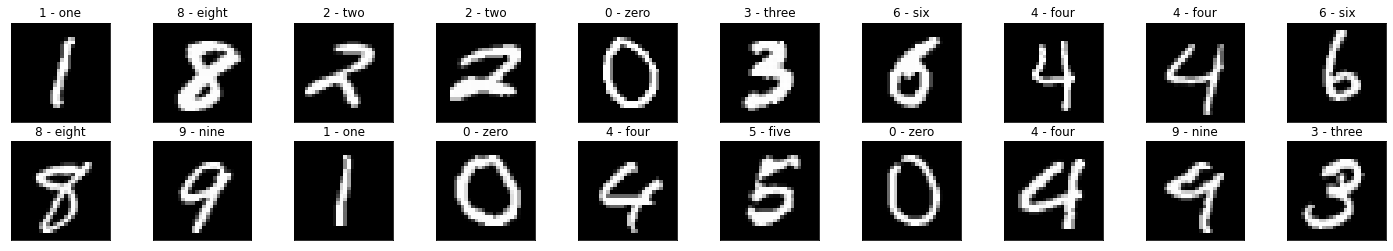

In [50]:
# CELL TO BE COMPLETED
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data_iter = iter(train_loader)
images, labels = data_iter.next()
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(class_names[labels[idx].item()]))

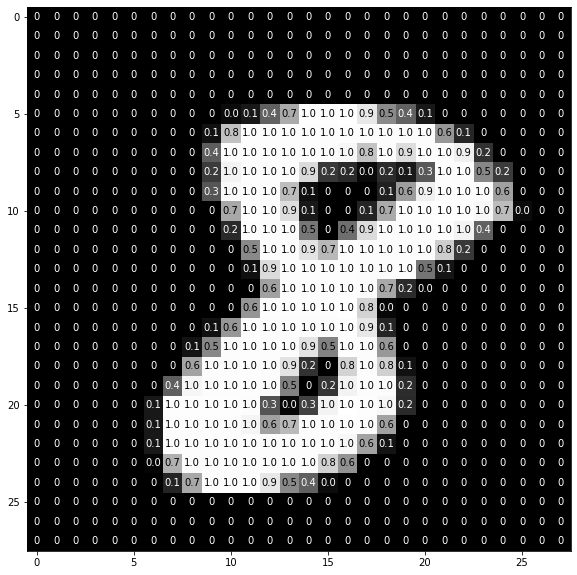

In [51]:
# CELL TO BE COMPLETED
img = np.squeeze(images[1])
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],1) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x), horizontalalignment='center', verticalalignment='center', color='white' if img[x][y]<thresh else 'black')

## 2- Multi-Layer Perceptron (MLP) <a class="anchor" id="section_2"></a>

First, let us use a multi-layer perceptron (MLP) to automatically classify Fashion-MNIST images.

#### **MLP architecture** - Define a MPL architecture with (at least) 2 fully-connected as well as dropout layers. <a class="anchor" id="question_2_1"></a> **Test a model with and without dropout** (see https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [77]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module): 
    def __init__(self): # FUNCTION TO BE COMPLETED
        super(MLP,self).__init__()
        hidden_1, hidden_2 = 512, 256
        self.fc1 = nn.Linear(28*28, hidden_1)
        self.fc2 = nn.Linear(hidden_1,hidden_2)
        self.fc3 = nn.Linear(hidden_2,10)
        self.dropout = nn.Dropout(0.)
        
    def forward(self,x): # FUNCTION TO BE COMPLETED
        x = x.view(-1,28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

#### **Traning scheme** - Train the pre-defined MLP network with cross entropy as loss function and stochastic gradient descent as optimization algorithm. <a class="anchor" id="question_2_2"></a>

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cuda


In [80]:
model_1 = MLP()
model_1.to(device=device)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [65]:
criterion = nn.CrossEntropyLoss() # TO DO

In [82]:
optimizer = torch.optim.SGD(model_1.parameters(),lr = 0.01) # TO DO

In [81]:
n_epochs = 100

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer): # FUNCTION TO BE COMPLETED

  train_losses, valid_losses = [], []
  valid_loss_min = np.Inf

  for epoch in range(n_epochs):
      train_loss, valid_loss = 0, 0
      
      model.train()
      for data, label in train_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          optimizer.zero_grad()
          output = model(data)
          loss = criterion(output, label)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * data.size(0)
      
      model.eval()
      for data, label in valid_loader:
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.long)
          with torch.no_grad():
              output = model(data)
          loss = criterion(output,label)
          valid_loss += loss.item() * data.size(0)

      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      
      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss
      
  return train_losses, valid_losses      

In [83]:
train_losses_1, valid_losses_1 = training(n_epochs, train_loader, valid_loader, model_1, criterion, optimizer) # TO DO

epoch: 1 	training Loss: 2.261337 	validation Loss: 2.212522
validation loss decreased (inf --> 2.212522).  Saving model ...
epoch: 2 	training Loss: 2.100674 	validation Loss: 1.964308
validation loss decreased (2.212522 --> 1.964308).  Saving model ...
epoch: 3 	training Loss: 1.670615 	validation Loss: 1.396098
validation loss decreased (1.964308 --> 1.396098).  Saving model ...
epoch: 4 	training Loss: 1.087773 	validation Loss: 0.943228
validation loss decreased (1.396098 --> 0.943228).  Saving model ...
epoch: 5 	training Loss: 0.761633 	validation Loss: 0.736387
validation loss decreased (0.943228 --> 0.736387).  Saving model ...
epoch: 6 	training Loss: 0.605040 	validation Loss: 0.627894
validation loss decreased (0.736387 --> 0.627894).  Saving model ...
epoch: 7 	training Loss: 0.514603 	validation Loss: 0.562282
validation loss decreased (0.627894 --> 0.562282).  Saving model ...
epoch: 8 	training Loss: 0.455182 	validation Loss: 0.519511
validation loss decreased (0.56228

#### **Check the training convergence** - Plot the evolution of the loss function for both training and validation sets with respect to epochs to study the convergence of the training process. <a class="anchor" id="question_2_3"></a>

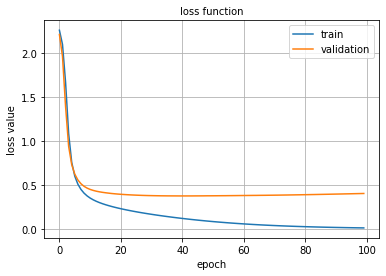

In [84]:
# CELL TO BE COMPLETED
plt.plot(range(n_epochs), train_losses_1)
plt.plot(range(n_epochs), valid_losses_1)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)
plt.grid()

Let us load the model corresponding to the lowest validation loss.

In [16]:
model_1.load_state_dict(torch.load('model.pt', map_location=device))

<All keys matched successfully>

#### **Testing the trained MLP model ** - Test the best model on (unseen) test data and evaluate it’s performance in terms of overall and per-class accuracy scores. <a class="anchor" id="question_2_4"></a>

In [17]:
def evaluation(model, test_loader, criterion): # FUNCTION TO BE COMPLETED

  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  model.eval()
  for data, label in test_loader:
      data = data.to(device=device, dtype=torch.float32)
      label = label.to(device=device, dtype=torch.long)
      with torch.no_grad():
          output = model(data)
      loss = criterion(output, label)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)
      correct = np.squeeze(pred.eq(label.data.view_as(pred)))
      for i in range(len(label)):
          digit = label.data[i]
          class_correct[digit] += correct[i].item()
          class_total[digit] += 1

  test_loss = test_loss/len(test_loader.sampler)
  print('test Loss: {:.6f}\n'.format(test_loss))
  for i in range(10):
      print('test accuracy of %s: %2d%% (%2d/%2d)' % (class_names[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
  print('\ntest accuracy (overall): %2.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

In [18]:
evaluation(model_1, test_loader, criterion) # TO DO

test Loss: 0.062930

test accuracy of 0 - zero: 99% (973/980)
test accuracy of 1 - one: 99% (1125/1135)
test accuracy of 2 - two: 98% (1013/1032)
test accuracy of 3 - three: 98% (995/1010)
test accuracy of 4 - four: 97% (955/982)
test accuracy of 5 - five: 97% (867/892)
test accuracy of 6 - six: 98% (939/958)
test accuracy of 7 - seven: 97% (998/1028)
test accuracy of 8 - eight: 97% (950/974)
test accuracy of 9 - nine: 97% (982/1009)

test accuracy (overall): 97.97% (9797/10000)


#### **Incorrect classifications** - Visualize some incorrect predictions by displaying test images and labels in the format: "predicted (ground-truth)". <a class="anchor" id="question_2_5"></a>

In [ ]:
def get_all_prediction(model, loader): # FUNCTION TO BE COMPLETED
    preds = torch.tensor([], dtype=torch.long)
    targets = torch.tensor([], dtype=torch.long)
    for data, label in loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        with torch.no_grad():
            output = model(data)
        targets = torch.cat((targets, label.cpu()), dim = 0)
        preds = torch.cat((preds, torch.max(output.cpu(), 1)[1]), dim = 0)
    return targets.numpy(), preds.numpy()

In [ ]:
targets, preds_1 = get_all_prediction(model_1, test_loader) # TO DO

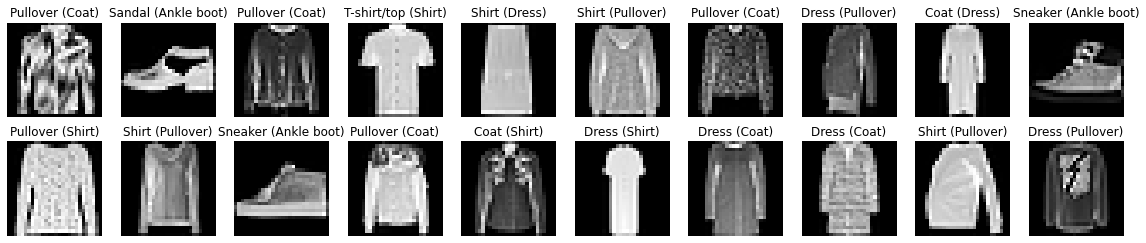

In [ ]:
index = np.where(preds_1 - targets != 0)[0]
test_set_array = test_data.data.numpy()
plt.figure(figsize=(20, 4))
for i in range(20):
  plt.subplot(2, 10, i + 1)
  plt.axis('off')
  plt.imshow(test_set_array[index[i],:,:], cmap='gray')
  plt.title("{} ({})".format(class_names[preds_1[index[i]]], class_names[targets[index[i]]]))
plt.show()